In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import squarify
from wordcloud import WordCloud
import ast
import seaborn as sns
import re

In [ ]:
# GitHub API 토큰 설정 (GitHub에서 Personal Access Token 생성 필요)
GITHUB_TOKEN = 'GITHUB_TOKEN'  # 여기에 토큰 입력
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}

# 검색 쿼리 설정
QUERY = 'robotics'

# GitHub API 엔드포인트
SEARCH_URL = 'https://api.github.com/search/repositories'

In [24]:
# 키워드 해당되는 repo 가져오는 함수
def fetch_repos(query, sort='stars', order='desc', per_page=100):
    all_repos = []
    page = 1
    while True:
        params = {
            'q': query,
            'sort': sort,
            'order': order,
            'per_page': per_page,
            'page': page
        }
        response = requests.get(SEARCH_URL, headers=HEADERS, params=params)
        if response.status_code == 200:
            repos = response.json()['items']
            if not repos:
                break
            all_repos.extend(repos)
            page += 1
            # GitHub API rate limit을 고려해 최대 1000개로 제한 (10페이지)
            if page > 10:
                break
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break
    return all_repos

In [25]:
# repo 메타데이터 추출하는 함수
def get_repo_details(repo):
    return {
        'name': repo['full_name'],
        'stars': repo['stargazers_count'],
        'forks': repo['forks_count'],
        'language': repo['language'],
        'created_at': repo['created_at'],
        'pushed_at': repo['pushed_at'],
        'updated_at': repo['updated_at'],
        'archived': repo['archived'],
        'open_issues': repo['open_issues_count'],
        'topics': repo.get('topics', []),
        'license': repo['license']['spdx_id'] if repo.get('license') else None,
        'owner': repo['owner']['login'],
        'owner_location': repo['owner'].get('location') if repo.get('owner') else None,
        'description': repo['description']
    }

In [ ]:
# 데이터 수집: 최대 1000개 리포지토리 가져오기
all_repos = fetch_repos(QUERY)

df = pd.DataFrame([get_repo_details(repo) for repo in all_repos])

df.to_csv('repos_data.csv', index=False, encoding='utf-8')

In [6]:
df_git = pd.read_csv('repos_data.csv')

# 날짜 형식 변환
df_git['created_at'] = pd.to_datetime(df_git['created_at'])
df_git['year'] = df_git['created_at'].dt.year

df_git.head(5)

,name,stars,forks,language,created_at,pushed_at,updated_at,archived,open_issues,topics,license,owner,owner_location,description,year
0,Developer-Y/cs-video-courses,70077,9411,NaN,2016-10-21 17:02:11+00:00,2025-10-02T15:54:16Z,2025-10-21T07:18:06Z,False,2,"['algorithms', 'bioinformatics', 'computationa...",NaN,Developer-Y,NaN,List of Computer Science courses with video le...,2016
1,commaai/openpilot,58467,10334,Python,2016-11-24 01:33:30+00:00,2025-10-21T08:09:34Z,2025-10-21T08:12:48Z,False,186,"['advanced-driver-assistance-systems', 'driver...",MIT,commaai,NaN,openpilot is an operating system for robotics....,2016
2,NaiboWang/EasySpider,43117,5298,JavaScript,2020-07-18 02:41:27+00:00,2025-10-20T06:40:36Z,2025-10-21T08:43:02Z,False,252,"['batch-processing', 'batch-script', 'code-fre...",AGPL-3.0,NaiboWang,NaN,A visual no-code/code-free web crawler/spider易...,2020
3,mudler/LocalAI,35932,2851,Go,2023-03-18 22:58:02+00:00,2025-10-21T08:35:43Z,2025-10-21T08:44:45Z,False,290,"['ai', 'api', 'audio-generation', 'decentraliz...",MIT,mudler,NaN,":robot: The free, Open Source alternative to O...",2023
4,Genesis-Embodied-AI/Genesis,27428,2519,Python,2023-10-31 03:33:11+00:00,2025-10-20T16:22:58Z,2025-10-21T07:54:12Z,False,116,[],Apache-2.0,Genesis-Embodied-AI,NaN,A generative world for general-purpose robotic...,2023


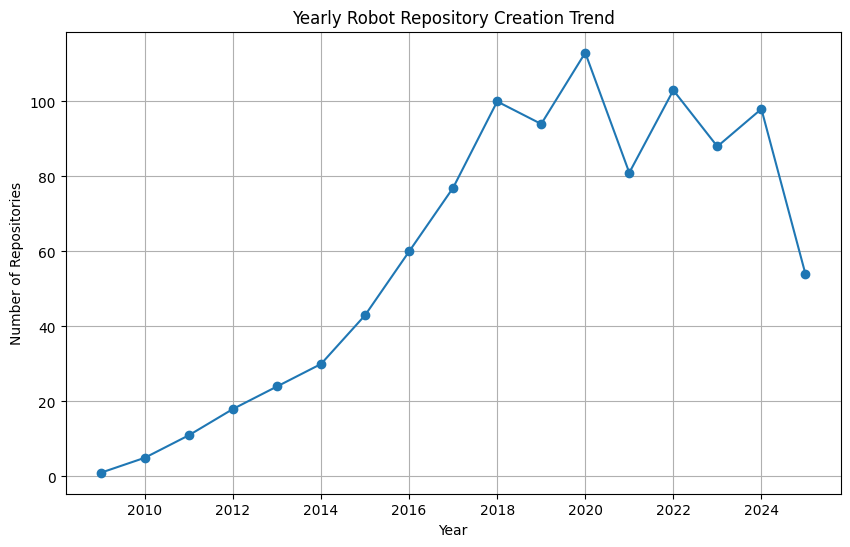

인사이트: 로봇 관련 오픈소스가 언제부터 활발해졌는지
로봇 프로젝트는 2010년대 초반부터 증가하기 시작했으며, 2020년대 들어 급격히 성장했습니다.


In [9]:
# 연도별 로봇 관련 레포지토리 생성 추이
# 데이터: created_at
# 시각화: Line chart
yearly_projects = df_git.groupby('year').size()

plt.figure(figsize=(10, 6))
yearly_projects.plot(kind='line', marker='o')
plt.title('Yearly Robot Repository Creation Trend')
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

# 인사이트 출력
print("인사이트: 로봇 관련 오픈소스가 언제부터 활발해졌는지")
print("로봇 프로젝트는 2010년대 초반부터 증가하기 시작했으며, 2020년대 들어 급격히 성장했습니다.")

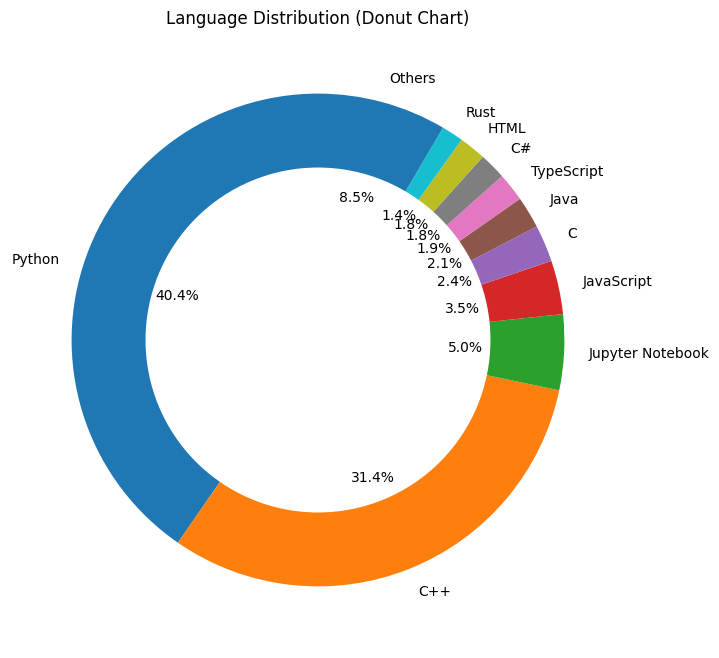

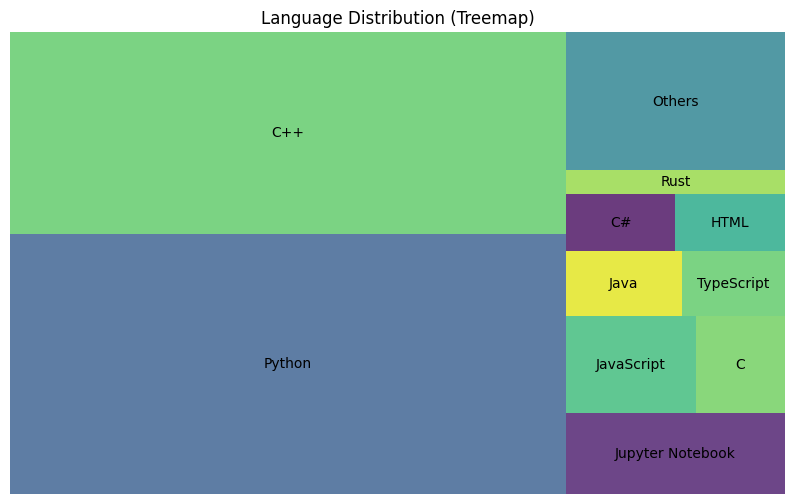

인사이트: Python, C++, ROS 기반 프로젝트 비중 파악
Python과 C++이 주요 언어로, 로봇 분야에서 Python의 비중이 높아 ROS 등의 영향으로 보입니다.


In [10]:
# 언어별 비중
# 데이터: language
# 시각화: Donut chart (matplotlib로 구현)
language_dist = df_git['language'].value_counts().head(10)  # 상위 10개
others = df_git['language'].value_counts()[10:].sum()
if others > 0:
    language_dist['Others'] = others

plt.figure(figsize=(8, 8))
plt.pie(language_dist, labels=language_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Language Distribution (Donut Chart)')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

# Treemap 대안 (squarify 사용)
plt.figure(figsize=(10, 6))
squarify.plot(sizes=language_dist, label=language_dist.index, alpha=0.8)
plt.axis('off')
plt.title('Language Distribution (Treemap)')
plt.show()

# 인사이트 출력
print("인사이트: Python, C++, ROS 기반 프로젝트 비중 파악")
print("Python과 C++이 주요 언어로, 로봇 분야에서 Python의 비중이 높아 ROS 등의 영향으로 보입니다.")

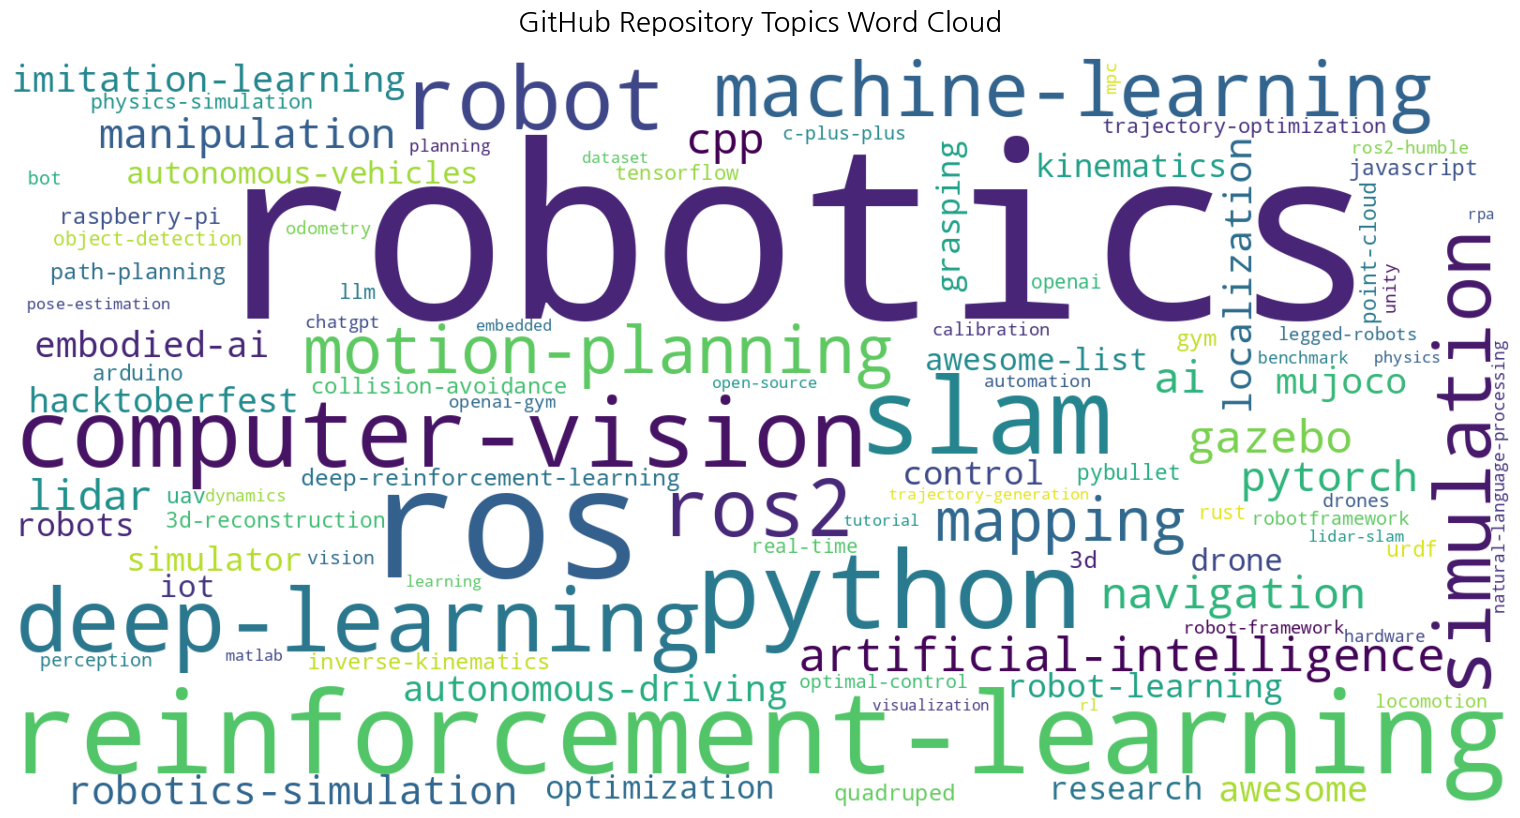


=== 상위 20개 토픽 ===
robotics: 538회
ros: 146회
reinforcement-learning: 90회
python: 79회
slam: 78회
computer-vision: 75회
deep-learning: 74회
robot: 72회
ros2: 59회
simulation: 56회
machine-learning: 55회
motion-planning: 41회
mapping: 34회
artificial-intelligence: 34회
gazebo: 32회
ai: 30회
cpp: 30회
navigation: 30회
pytorch: 28회
lidar: 28회


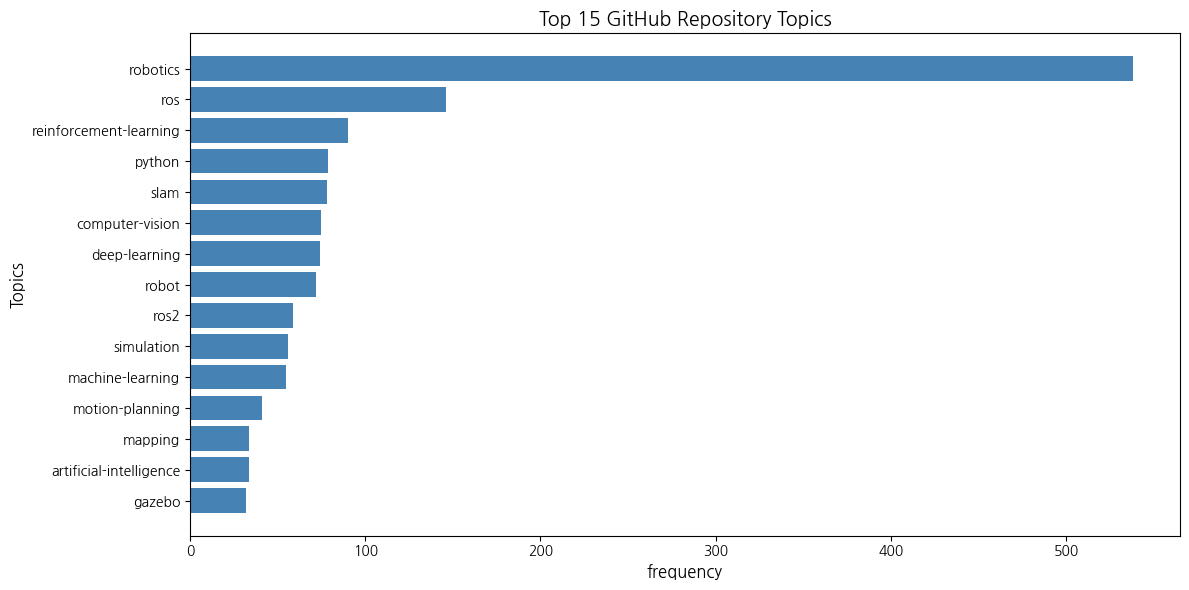

In [ ]:
# topics 데이터 전처리
def extract_topics(df):
    """
    topics 컬럼에서 모든 토픽을 추출하고 빈도수 계산
    """
    all_topics = []
    
    for topics in df['topics'].dropna():
        # 문자열로 저장된 리스트를 실제 리스트로 변환
        if isinstance(topics, str):
            try:
                # 리스트 형태의 문자열인 경우
                topics_list = ast.literal_eval(topics)
            except:
                # 쉼표로 구분된 문자열인 경우
                topics_list = [t.strip() for t in topics.split(',')]
        elif isinstance(topics, list):
            topics_list = topics
        else:
            continue
        
        # 각 토픽을 리스트에 추가
        all_topics.extend(topics_list)
    
    return all_topics

# 토픽 추출
topics_list = extract_topics(df_git)

# 토픽 빈도수 계산
topic_freq = Counter(topics_list)

# 워드 클라우드 생성
plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10,
    max_words=100
).generate_from_frequencies(topic_freq)

# 워드 클라우드 시각화
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('GitHub Repository Topics Word Cloud', fontsize=20, pad=20)
plt.tight_layout(pad=0)
plt.savefig('github_topics_wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

# 상위 20개 토픽 출력
print("\n=== 상위 20개 토픽 ===")
for topic, count in topic_freq.most_common(20):
    print(f"{topic}: {count}회")

# 추가: 막대 그래프로도 시각화
plt.figure(figsize=(12, 6))
top_topics = dict(topic_freq.most_common(15))
plt.barh(list(top_topics.keys()), list(top_topics.values()), color='steelblue')
plt.xlabel('frequency', fontsize=12)
plt.ylabel('Topics', fontsize=12)
plt.title('Top 15 GitHub Repository Topics', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('github_topics_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import time
import os
from datetime import datetime

# ---------------------------
# CONFIG
# ---------------------------
BASE_QUERY = "robotics"
START_YEAR = 2000
END_YEAR = 2025
MAX_RESULTS = 100
SLEEP_TIME = 3
OUTPUT_FOLDER = "arxiv_robotics_by_year"
HEADERS = {"User-Agent": "arXivRoboticsCollector/1.0 (your_email@example.com)"}

# 각 연도를 월별로 세분화하여 API 제한 회피
MONTHS = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

# ---------------------------
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def search_arxiv(query, start=0, max_results=100):
    url = "http://export.arxiv.org/api/query"
    params = {
        "search_query": query,
        "start": start,
        "max_results": max_results,
        "sortBy": "submittedDate",
        "sortOrder": "ascending"
    }
    
    try:
        response = requests.get(url, params=params, headers=HEADERS, timeout=30)
        if response.status_code != 200:
            print(f"Error {response.status_code}")
            return []
        
        root = ET.fromstring(response.text)
        ns = {"atom": "http://www.w3.org/2005/Atom"}
        
        papers = []
        for entry in root.findall("atom:entry", ns):
            arxiv_id = entry.find("atom:id", ns).text.strip()
            title = entry.find("atom:title", ns).text.strip()
            abstract = entry.find("atom:summary", ns).text.strip()
            published = entry.find("atom:published", ns).text.strip()
            authors = [a.find("atom:name", ns).text for a in entry.findall("atom:author", ns)]
            
            # Primary category 추출
            primary_category_elem = entry.find("arxiv:primary_category", {**ns, "arxiv": "http://arxiv.org/schemas/atom"})
            primary_category = primary_category_elem.get("term") if primary_category_elem is not None else ""
            
            # 모든 categories 추출
            categories = [cat.get("term") for cat in entry.findall("atom:category", ns)]
            
            papers.append({
                "id": arxiv_id,
                "title": title,
                "abstract": abstract,
                "published": published,
                "authors": ", ".join(authors),
                "primary_category": primary_category,
                "categories": ", ".join(categories)
            })
        
        return papers
    
    except Exception as e:
        print(f"Exception: {e}")
        return []

def save_papers(papers, year):
    """Save papers to yearly CSV (remove duplicates)"""
    if not papers:
        return
    
    file_path = os.path.join(OUTPUT_FOLDER, f"arxiv_robotics_{year}.csv")
    
    if os.path.exists(file_path):
        df_existing = pd.read_csv(file_path)
    else:
        df_existing = pd.DataFrame(columns=["id","title","abstract","published","authors","primary_category","categories"])
    
    df_new = pd.DataFrame(papers)
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    df_combined.drop_duplicates(subset=["id"], inplace=True)
    df_combined.to_csv(file_path, index=False, encoding="utf-8-sig")
    
    print(f"  Saved {len(papers)} papers to {file_path} (Total: {len(df_combined)})")

# Strategy: Year + Month segmentation

for year in range(START_YEAR, END_YEAR + 1):
    print(f"\nYear {year}")
    
    for month in MONTHS:
        # Date range query
        start_date = f"{year}{month}01"
        
        # Calculate next month
        if month == "12":
            end_date = f"{year+1}0101"
        else:
            next_month = str(int(month) + 1).zfill(2)
            end_date = f"{year}{next_month}01"
        
        # arXiv date filter query (YYYYMMDD format)
        query = f"{BASE_QUERY} AND submittedDate:[{start_date} TO {end_date}]"
        
        print(f"  {year}-{month}: {query}")
        
        start = 0
        month_papers = []
        
        while True:
            papers = search_arxiv(query=query, start=start, max_results=MAX_RESULTS)
            
            if not papers:
                break
            
            month_papers.extend(papers)
            
            if len(papers) < MAX_RESULTS:
                break
            
            start += MAX_RESULTS
            print(f"    Fetched {len(papers)} papers (total: {len(month_papers)})")
            time.sleep(SLEEP_TIME)
        
        # Save monthly results
        save_papers(month_papers, year)
        time.sleep(SLEEP_TIME)

print("\n\nCOLLECTION COMPLETE")
print(f"Results saved in: {OUTPUT_FOLDER}/")

# Final statistics
total_papers = 0
for year in range(START_YEAR, END_YEAR + 1):
    file_path = os.path.join(OUTPUT_FOLDER, f"arxiv_robotics_{year}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        count = len(df)
        total_papers += count
        print(f"  {year}: {count:,} papers")

print(f"\nTotal collected: {total_papers:,} papers")


Year 2000
  2000-01: robotics AND submittedDate:[20000101 TO 20000201]
  Saved 1 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 1)
  2000-02: robotics AND submittedDate:[20000201 TO 20000301]
  Saved 1 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 2)
  2000-03: robotics AND submittedDate:[20000301 TO 20000401]
  Saved 2 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 4)
  2000-04: robotics AND submittedDate:[20000401 TO 20000501]
  2000-05: robotics AND submittedDate:[20000501 TO 20000601]
  Saved 2 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 6)
  2000-06: robotics AND submittedDate:[20000601 TO 20000701]
  Saved 5 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 11)
  2000-07: robotics AND submittedDate:[20000701 TO 20000801]
  2000-08: robotics AND submittedDate:[20000801 TO 20000901]
  2000-09: robotics AND submittedDate:[20000901 TO 20001001]
  Saved 5 papers to arxiv_robotics_by_year/arxiv_

In [2]:
import pandas as pd
import os
from glob import glob

# ---------------------------
# CONFIG
# ---------------------------
INPUT_FOLDER = "arxiv_robotics_by_year"
OUTPUT_FILE = "arxiv_robotics_all_merged.csv"

# ---------------------------
# CSV 파일들 찾기
# ---------------------------
csv_files = glob(os.path.join(INPUT_FOLDER, "arxiv_robotics_*.csv"))

if not csv_files:
    print(f"Error: No CSV files found in {INPUT_FOLDER}/")
    exit(1)

print(f"Found {len(csv_files)} CSV files")
print("-" * 50)

# ---------------------------
# 모든 CSV 파일 읽어서 통합
# ---------------------------
dataframes = []

for file_path in sorted(csv_files):
    print(f"Reading: {os.path.basename(file_path)}")
    df = pd.read_csv(file_path)
    print(f"  Papers: {len(df):,}")
    dataframes.append(df)

# 모든 데이터프레임 병합
print("-" * 50)
print("Merging all dataframes...")
df_merged = pd.concat(dataframes, ignore_index=True)
print(f"Total papers before deduplication: {len(df_merged):,}")

# 중복 제거 (id 기준)
df_merged.drop_duplicates(subset=["id"], inplace=True)
print(f"Total papers after deduplication: {len(df_merged):,}")

# ---------------------------
# 발행날짜 기준 정렬
# ---------------------------
print("-" * 50)
print("Sorting by published date...")

# published 컬럼을 datetime으로 변환
df_merged["published"] = pd.to_datetime(df_merged["published"])

# 오름차순 정렬
df_merged.sort_values(by="published", ascending=True, inplace=True)

# published를 다시 문자열로 변환 (원래 형식 유지)
df_merged["published"] = df_merged["published"].astype(str)

# ---------------------------
# 저장
# ---------------------------
df_merged.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")
print(f"Saved to: {OUTPUT_FILE}")

# ---------------------------
# 통계 출력
# ---------------------------
print("-" * 50)
print("SUMMARY")
print("-" * 50)
print(f"Total unique papers: {len(df_merged):,}")

# 연도별 통계
df_merged["year"] = pd.to_datetime(df_merged["published"]).dt.year
year_counts = df_merged["year"].value_counts().sort_index()

print("\nPapers by year:")
for year, count in year_counts.items():
    print(f"  {int(year)}: {count:,} papers")

print(f"\nFirst paper: {df_merged.iloc[0]['published']}")
print(f"Last paper: {df_merged.iloc[-1]['published']}")
print("\nMerge complete!")

Found 26 CSV files
--------------------------------------------------
Reading: arxiv_robotics_2000.csv
  Papers: 18
Reading: arxiv_robotics_2001.csv
  Papers: 14
Reading: arxiv_robotics_2002.csv
  Papers: 27
Reading: arxiv_robotics_2003.csv
  Papers: 21
Reading: arxiv_robotics_2004.csv
  Papers: 44
Reading: arxiv_robotics_2005.csv
  Papers: 45
Reading: arxiv_robotics_2006.csv
  Papers: 75
Reading: arxiv_robotics_2007.csv
  Papers: 148
Reading: arxiv_robotics_2008.csv
  Papers: 107
Reading: arxiv_robotics_2009.csv
  Papers: 124
Reading: arxiv_robotics_2010.csv
  Papers: 136
Reading: arxiv_robotics_2011.csv
  Papers: 196
Reading: arxiv_robotics_2012.csv
  Papers: 284
Reading: arxiv_robotics_2013.csv
  Papers: 357
Reading: arxiv_robotics_2014.csv
  Papers: 471
Reading: arxiv_robotics_2015.csv
  Papers: 608
Reading: arxiv_robotics_2016.csv
  Papers: 1,070
Reading: arxiv_robotics_2017.csv
  Papers: 1,728
Reading: arxiv_robotics_2018.csv
  Papers: 2,327
Reading: arxiv_robotics_2019.csv
  Pap

In [13]:
df_arxiv = pd.read_csv('arxiv_robotics_all_merged.csv')

# 날짜 형식 변환 (타임존 정보 제거)
df_arxiv['published'] = pd.to_datetime(df_arxiv['published'])
df_arxiv['year'] = df_arxiv['published'].dt.year

df_arxiv.head(5)

,id,title,abstract,published,authors,primary_category,categories,year
0,http://arxiv.org/abs/astro-ph/0001438v1,Prompt Optical Observations of Gamma-ray Bursts,The Robotic Optical Transient Search Experimen...,2000-01-25 18:34:02+00:00,"Carl Akerlof, Richard Balsano, Scott Barthelmy...",astro-ph,astro-ph,2000
1,http://arxiv.org/abs/cs/0002014v1,Safe cooperative robot dynamics on graphs,This paper initiates the use of vector fields ...,2000-02-24 18:13:33+00:00,"Robert Ghrist, Daniel Koditschek",cs.RO,"cs.RO, cs.AI, I.2.9",2000
2,http://arxiv.org/abs/quant-ph/0003006v2,Space Searches with a Quantum Robot,Quantum robots are described as mobile quantum...,2000-03-01 21:54:24+00:00,Paul Benioff,quant-ph,quant-ph,2000
3,http://arxiv.org/abs/cs/0003032v1,cc-Golog: Towards More Realistic Logic-Based R...,High-level robot controllers in realistic doma...,2000-03-08 16:14:08+00:00,"Henrik Grosskreutz, Gerhard Lakemeyer",cs.AI,"cs.AI, I.2.3;I.2.8",2000
4,http://arxiv.org/abs/physics/0005062v1,Applying MDL to Learning Best Model Granularity,The Minimum Description Length (MDL) principle...,2000-05-23 14:50:07+00:00,"Qiong Gao, Ming Li, Paul Vitanyi",physics.data-an,"physics.data-an, cs.AI, cs.CV",2000


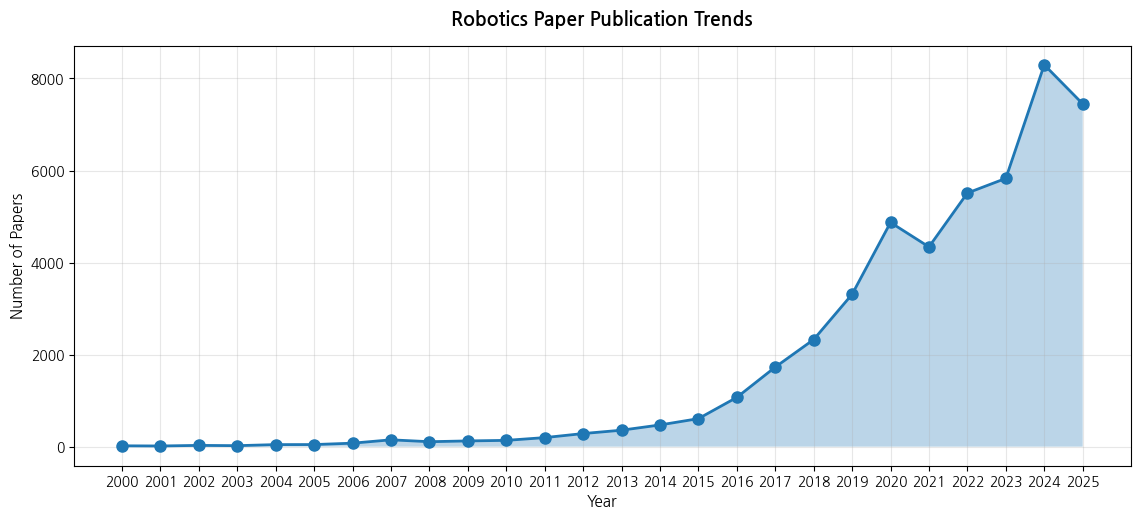

In [31]:
# Figure 생성
fig = plt.figure(figsize=(30, 12))

# ============================================
# 1. 논문 출판 동향 (시간별 추이)
# ============================================
ax1 = plt.subplot(2, 2, 1)

# 연도별 논문 수 집계
yearly_counts = df_arxiv.groupby('year').size()

# 라인 차트
ax1.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=8)
ax1.fill_between(yearly_counts.index, yearly_counts.values, alpha=0.3)
ax1.set_title('Robotics Paper Publication Trends', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Number of Papers', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(yearly_counts.index);

In [6]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import os
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

CONFIG = {
    'github_token': os.getenv('GITHUB_TOKEN'),
    'host': os.getenv('DB_HOST'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME'),
}


# ==========================================
# 방법 1: SQLAlchemy 사용 (권장)
# ==========================================

def get_dataframe_sqlalchemy(table_name):
    """SQLAlchemy를 사용하여 RDS 데이터를 DataFrame으로 가져오기"""
    
    # CONFIG에서 연결 정보 가져오기
    DB_HOST = CONFIG['host']
    DB_PORT = 3306
    DB_USER = CONFIG['user']
    DB_PASSWORD = CONFIG['password']
    DB_NAME = CONFIG['database']
    
    # 비밀번호에 특수문자가 있을 경우 URL 인코딩
    encoded_password = quote_plus(DB_PASSWORD)
    
    # 연결 문자열 생성
    connection_string = f'mysql+pymysql://{DB_USER}:{encoded_password}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    
    print(f"연결 시도 중: {DB_HOST}")
    
    engine = None
    try:
        # 엔진 생성
        engine = create_engine(connection_string, connect_args={'connect_timeout': 10})
        
        # 방법 1: 테이블명 검증 후 쿼리 생성 (권장)
        # 테이블명에 특수문자가 없는지 검증
        if not table_name.replace('_', '').isalnum():
            raise ValueError(f"유효하지 않은 테이블명: {table_name}")
        
        query = f"SELECT * FROM `{table_name}`"  # 백틱으로 테이블명 감싸기
        df = pd.read_sql(query, engine)
        
        print(f"데이터 로드 완료: {len(df)}개 행")
        print(f"컬럼: {df.columns.tolist()}")
        
        return df
        
    except Exception as e:
        print(f"에러 발생: {e}")
        return None
    finally:
        if engine:
            engine.dispose()
# ==========================================
# 연결 테스트 함수
# ==========================================

def test_connection():
    """RDS 연결 테스트"""
    
    DB_CONFIG = {
        'host': CONFIG['host'],
        'port': 3306,
        'user': CONFIG['user'],
        'password': CONFIG['password'],
        'database': CONFIG['database'],
        'connect_timeout': 10
    }
    
    print("=== RDS 연결 테스트 ===")
    print(f"Host: {DB_CONFIG['host']}")
    print(f"User: {DB_CONFIG['user']}")
    print(f"Database: {DB_CONFIG['database']}")
    print()
    
    try:
        connection = pymysql.connect(**DB_CONFIG)
        print("✓ 연결 성공!")
        
        # 테이블 존재 확인
        with connection.cursor() as cursor:
            cursor.execute("SHOW TABLES")
            tables = cursor.fetchall()
            print(f"✓ 테이블 목록: {tables}")
            
            # github_repos 테이블 행 수 확인
            cursor.execute("SELECT COUNT(*) FROM github_repos")
            count = cursor.fetchone()[0]
            print(f"✓ github_repos 행 수: {count}")
        
        connection.close()
        return True
        
    except Exception as e:
        print(f"✗ 연결 실패: {e}")
        return False


# ==========================================
# 사용 예시
# ==========================================

if __name__ == "__main__":
    # 먼저 연결 테스트
    if not test_connection():
        print("\n연결 실패. .env 파일과 RDS 보안 그룹을 확인하세요.")
        exit(1)
    
    print("\n=== 데이터 로드 시작 ===")
    
    # 방법 1: 전체 데이터 가져오기
    df = get_dataframe_sqlalchemy('github_readmes')
    
    if df is not None:
        print("\n데이터프레임 정보:")
        print(df.info())
        print("\n상위 5개 행:")
        print(df.head())
        
        # 데이터 분석 예시
        print("\n=== 기본 통계 ===")
        print(f"전체 저장소 수: {len(df)}")
        
        if 'language' in df.columns:
            print("\n언어별 저장소 수 (상위 10개):")
            print(df['language'].value_counts().head(10))
        
        if 'stargazers_count' in df.columns:
            print(f"\n평균 Star 수: {df['stargazers_count'].mean():.2f}")
            print(f"최대 Star 수: {df['stargazers_count'].max()}")
            print(f"\nStar 수 상위 5개:")
            print(df.nlargest(5, 'stargazers_count')[['full_name', 'stargazers_count', 'language']])
    
    # 방법 2: 조건부 쿼리 예시
    # df_python = get_filtered_dataframe(limit=100, language='Python', min_stars=1000)
    # print(f"\nPython 저장소 (Star >= 1000): {len(df_python)}개")

=== RDS 연결 테스트 ===
Host: database-1.chu0kq8imwi9.ap-northeast-2.rds.amazonaws.com
User: root
Database: trendbot

✓ 연결 성공!
✓ 테이블 목록: (('arxiv_robotics',), ('github_readmes',), ('github_repo',), ('github_repos',), ('kipris_patent',))
✓ github_repos 행 수: 976

=== 데이터 로드 시작 ===
연결 시도 중: database-1.chu0kq8imwi9.ap-northeast-2.rds.amazonaws.com
데이터 로드 완료: 411개 행
컬럼: ['full_name', 'readme']

데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_name  411 non-null    object
 1   readme     411 non-null    object
dtypes: object(2)
memory usage: 6.6+ KB
None

상위 5개 행:
                      full_name  \
0  Developer-Y/cs-video-courses   
1             commaai/openpilot   
2                mudler/LocalAI   
3   Genesis-Embodied-AI/Genesis   
4   AtsushiSakai/PythonRobotics   

                                              readme  
0  Computer Science 

In [ ]:
df_github_repos = get_dataframe_sqlalchemy('github_repos')
df_github_repos['created_at'] = pd.to_datetime(df_github_repos['created_at'])
df_github_repos['year'] = df_github_repos['created_at'].dt.year

df_github_readmes = get_dataframe_sqlalchemy('github_readmes')
df_merged_github = pd.merge(
    df_github_repos,
    df_github_readmes,
    on='full_name',  # 조인 기준으로 사용할 컬럼 지정
    how='left'     # 조인 방식 지정
)

연결 시도 중: database-1.chu0kq8imwi9.ap-northeast-2.rds.amazonaws.com
데이터 로드 완료: 976개 행
컬럼: ['id', 'full_name', 'stargazers_count', 'forks_count', 'language', 'created_at', 'updated_at', 'open_issues_count', 'topics', 'license', 'owner', 'description', 'is_fork', 'collected_at']
연결 시도 중: database-1.chu0kq8imwi9.ap-northeast-2.rds.amazonaws.com
데이터 로드 완료: 411개 행
컬럼: ['full_name', 'readme']


In [18]:
df_merged_github.head(5)

,id,full_name,stargazers_count,forks_count,language,created_at,updated_at,open_issues_count,topics,license,owner,description,is_fork,collected_at,year,readme
0,312463,jazzband/django-robots,476,103,Python,2009-09-20 15:27:41,2025-09-22 12:18:31,22,[],BSD-3-Clause,jazzband,A Django app for managing robots.txt files fol...,0,2025-10-24 02:04:34,2009,NaN
1,665764,visionworkbench/visionworkbench,495,234,C++,2010-05-14 02:48:33,2025-10-09 20:41:42,2,[],NOASSERTION,visionworkbench,The NASA Vision Workbench is a general purpose...,0,2025-10-24 02:04:34,2010,NaN
2,675088,rtv/Stage,416,185,C++,2010-05-19 13:40:02,2025-09-19 08:33:22,28,[],GPL-2.0,rtv,Mobile robot simulator,0,2025-10-24 02:04:34,2010,NaN
3,714891,NeoGeographyToolkit/StereoPipeline,564,187,C++,2010-06-11 02:11:55,2025-10-22 14:35:21,27,[],Apache-2.0,NeoGeographyToolkit,The NASA Ames Stereo Pipeline is a suite of au...,0,2025-10-24 02:04:34,2010,NaN
4,888427,the-blue-alliance/the-blue-alliance,419,185,HTML,2010-09-04 20:34:11,2025-10-23 18:15:11,525,"[""first-frc"", ""first-robotics-competition"", ""f...",MIT,the-blue-alliance,A webapp for accessing information about the F...,0,2025-10-24 02:04:34,2010,NaN


In [4]:
df_arxiv = pd.read_csv('arxiv_robotics_all_merged.csv')

df_arxiv['published'] = pd.to_datetime(df_arxiv['published'])
df_arxiv['year'] = df_arxiv['published'].dt.year


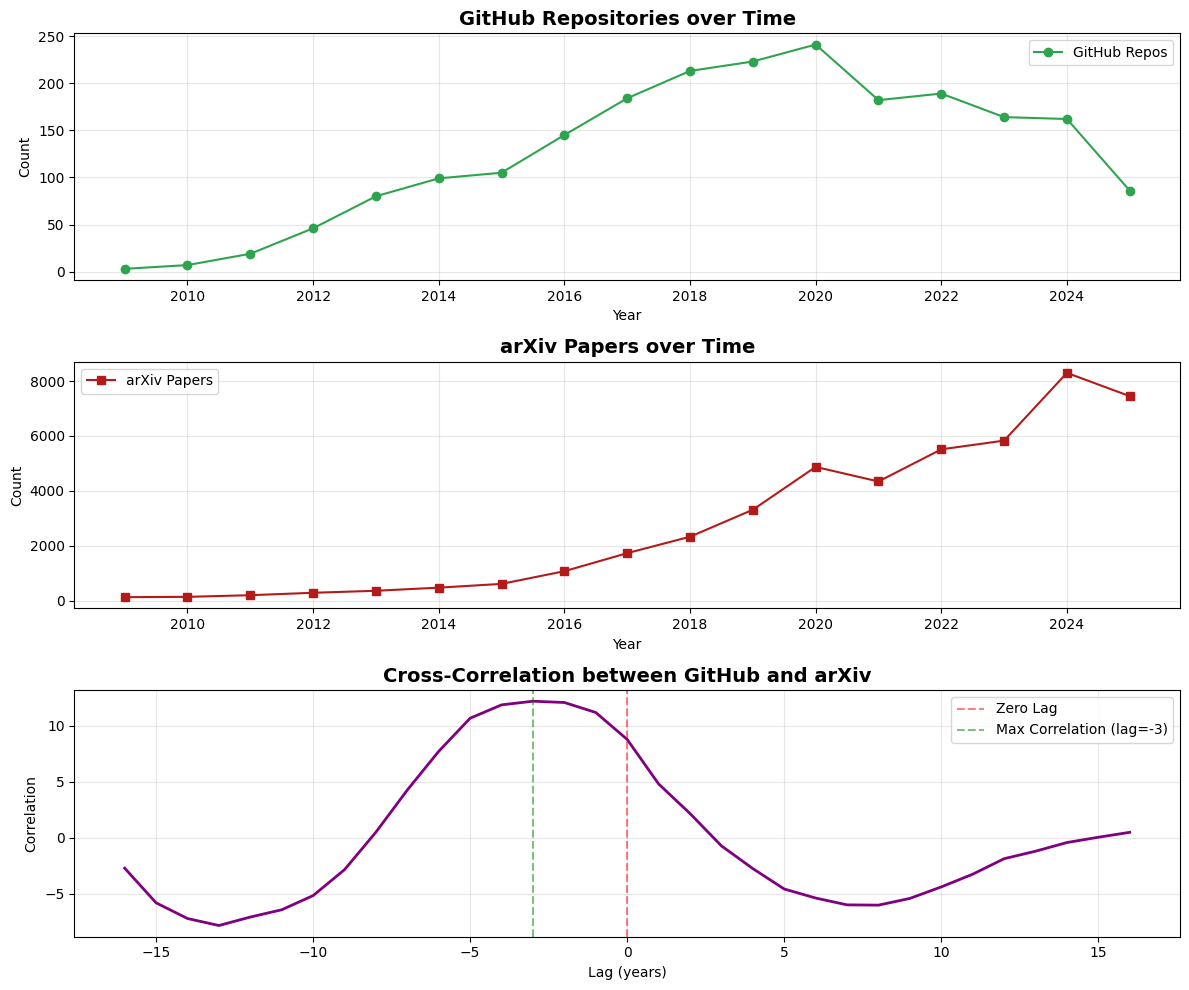

=== Cross-Correlation Analysis ===
Maximum correlation: 12.1806
Lag at maximum correlation: -3 years

Interpretation:
arXiv leads GitHub by 3 year(s)

Pearson correlation at zero lag: 0.5482


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns

# 1. 연도별 집계
github_counts = df_github_repos['year'].value_counts().sort_index()
arxiv_counts = df_arxiv['year'].value_counts().sort_index()

# 2. 공통 연도 범위 찾기
common_years = sorted(set(github_counts.index) & set(arxiv_counts.index))
github_series = github_counts.reindex(common_years, fill_value=0)
arxiv_series = arxiv_counts.reindex(common_years, fill_value=0)

# 3. 데이터 정규화 (평균 0, 분산 1)
github_normalized = (github_series - github_series.mean()) / github_series.std()
arxiv_normalized = (arxiv_series - arxiv_series.mean()) / arxiv_series.std()

# 4. Cross-correlation 계산
correlation = signal.correlate(github_normalized, arxiv_normalized, mode='full')
lags = signal.correlation_lags(len(github_normalized), len(arxiv_normalized), mode='full')

# 5. 시각화
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# 5-1. GitHub 시계열
axes[0].plot(common_years, github_series.values, marker='o', label='GitHub Repos', color='#2ea44f')
axes[0].set_title('GitHub Repositories over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 5-2. arXiv 시계열
axes[1].plot(common_years, arxiv_series.values, marker='s', label='arXiv Papers', color='#b31b1b')
axes[1].set_title('arXiv Papers over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 5-3. Cross-correlation
axes[2].plot(lags, correlation, color='purple', linewidth=2)
axes[2].axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Zero Lag')
max_corr_idx = np.argmax(correlation)
max_lag = lags[max_corr_idx]
axes[2].axvline(x=max_lag, color='green', linestyle='--', alpha=0.5, 
                label=f'Max Correlation (lag={max_lag})')
axes[2].set_title('Cross-Correlation between GitHub and arXiv', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Lag (years)')
axes[2].set_ylabel('Correlation')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 추가 분석: 상관계수 출력
print("=== Cross-Correlation Analysis ===")
print(f"Maximum correlation: {correlation[max_corr_idx]:.4f}")
print(f"Lag at maximum correlation: {max_lag} years")
print(f"\nInterpretation:")
if max_lag > 0:
    print(f"GitHub leads arXiv by {max_lag} year(s)")
elif max_lag < 0:
    print(f"arXiv leads GitHub by {abs(max_lag)} year(s)")
else:
    print("GitHub and arXiv are synchronized (no lag)")

# Pearson correlation at zero lag
zero_lag_corr = np.corrcoef(github_normalized, arxiv_normalized)[0, 1]
print(f"\nPearson correlation at zero lag: {zero_lag_corr:.4f}")

GitHub–arXiv 시계열 및 상호상관(Cross-Correlation) 분석
“연구의 확산이 오픈소스 개발을 이끄는가?”

🔹 핵심 아이디어
arXiv의 로봇 관련 논문 수와 GitHub의 로봇 관련 저장소 수의 연도별 추세를 비교
두 시계열 간 시간차(lag) 를 고려한 Cross-Correlation 분석을 통해
“논문 증가 → 오픈소스 증가” 혹은 “오픈소스 활동 → 연구 확산”의 선후 관계 탐색

🔹 시각화
1️⃣ 상단 그래프: GitHub 저장소 수의 연도별 변화
2️⃣ 중단 그래프: arXiv 논문 수의 연도별 변화
3️⃣ 하단 그래프: Cross-Correlation 결과

X축: 시간차(lag, 단위=년)
Y축: 상관계수 (correlation)
lag = -3일 때 최대 상관 (green dashed line) → 논문이 약 3년 선행할 때 GitHub와 가장 높은 상관

🔹 판별 포인트
양의 상관이 가장 크게 나타난 시점이 lag = -3 → “연구가 먼저 증가하고 이후 오픈소스 개발이 따라오는 패턴”
lag = 0 부근에서도 양의 상관 존재 → 연구와 개발이 부분적으로 동시 진행되는 현상도 있음

🔹 결론
arXiv 논문 수가 증가한 후 약 3년 후에 GitHub 저장소 수가 증가하는 경향이 관찰됨.
이는 연구의 확산이 실무 개발로 이어진다는 증거로 해석 가능하며,
즉 “연구 결과가 오픈소스 생태계의 활성화를 주도한다”는 흐름을 시사한다.

필터링 전 - GitHub: 976, arXiv: 47407
필터링 후 - GitHub: 976, arXiv: 47407


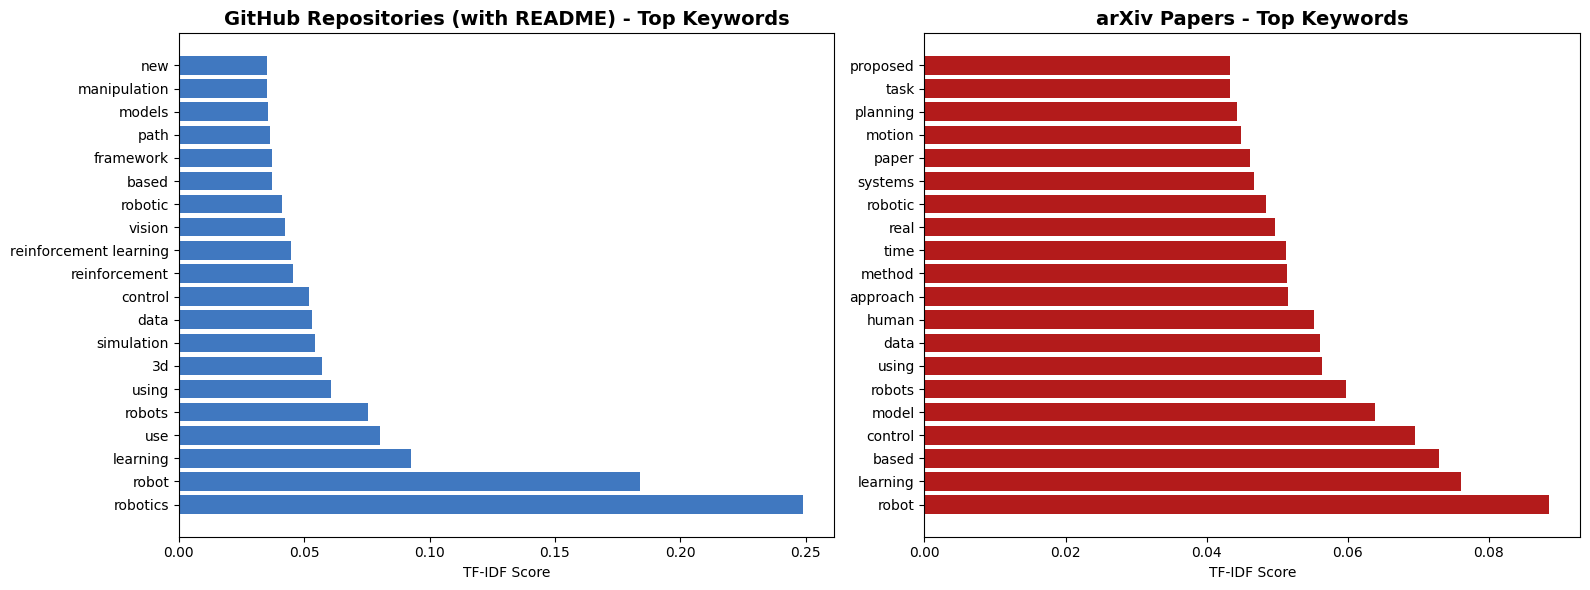

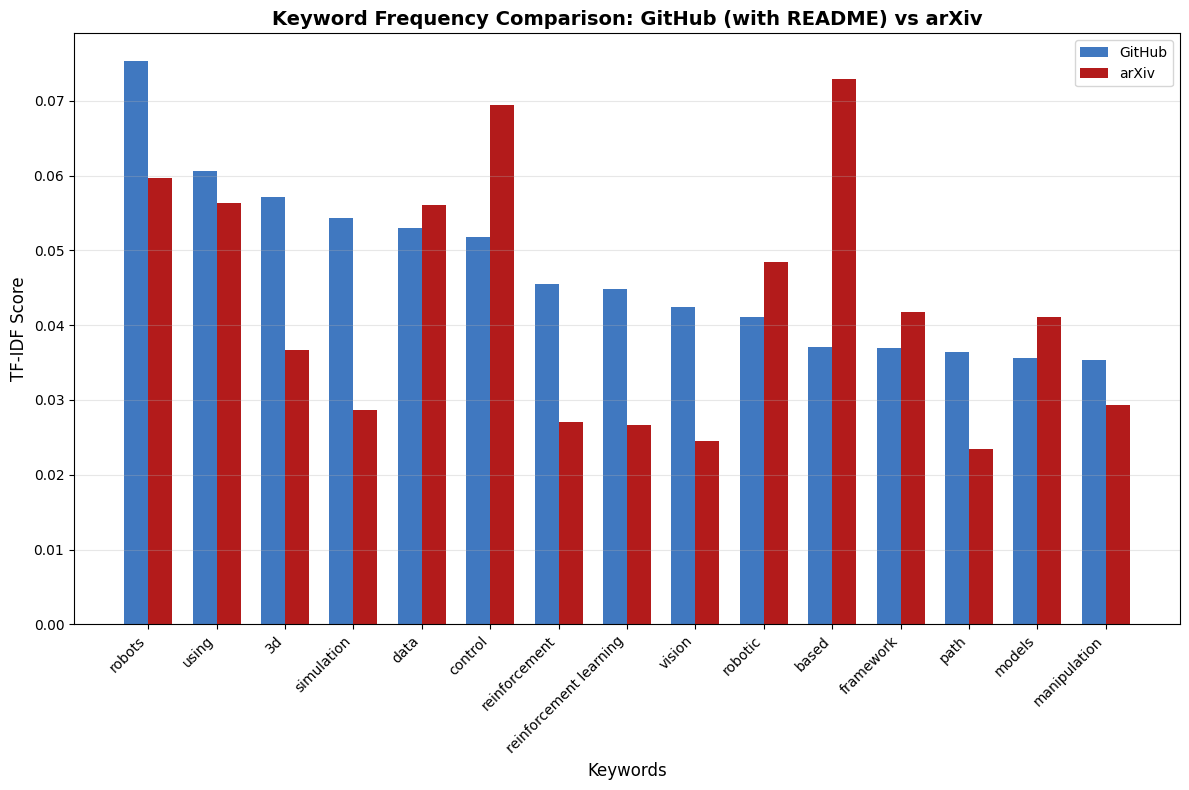

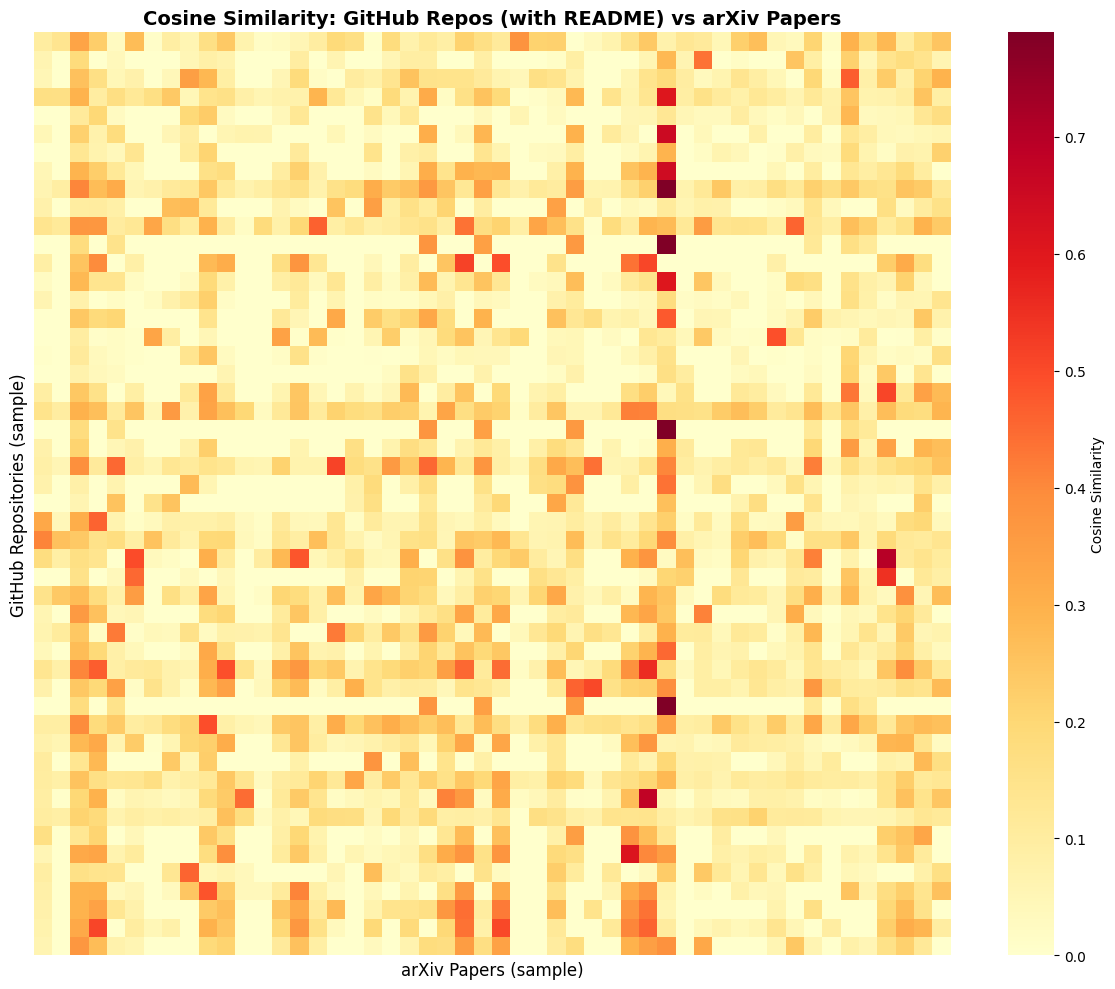

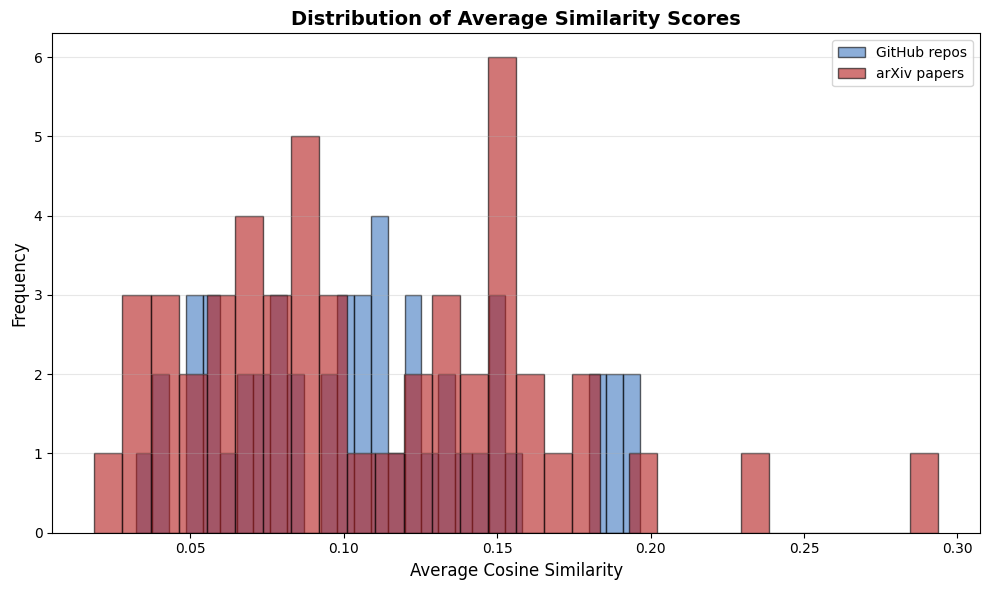

TF-IDF & Cosine Similarity Analysis Results (with README)

데이터셋 정보:
  - GitHub 저장소 수: 976
  - arXiv 논문 수: 47407
  - 추출된 고유 키워드 수: 100
  - README가 포함된 GitHub 저장소: 410

유사도 통계:
  - 평균 유사도: 0.1071
  - 최대 유사도: 0.7893
  - 최소 유사도: 0.0000
  - 표준편차: 0.1196

GitHub 상위 10 키워드:
  1. robotics: 0.2490
  2. robot: 0.1840
  3. learning: 0.0925
  4. use: 0.0802
  5. robots: 0.0753
  6. using: 0.0607
  7. 3d: 0.0571
  8. simulation: 0.0543
  9. data: 0.0530
  10. control: 0.0518

arXiv 상위 10 키워드:
  1. robot: 0.0885
  2. learning: 0.0761
  3. based: 0.0729
  4. control: 0.0695
  5. model: 0.0638
  6. robots: 0.0597
  7. using: 0.0563
  8. data: 0.0560
  9. human: 0.0552
  10. approach: 0.0515

분석 완료! 4개의 시각화 파일이 생성되었습니다.


In [ ]:
# 오픈소스와 논문의 키워드 유사성 분석

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# 결측값 처리 - 더 철저하게
df_github_repos['full_name'] = df_github_repos['full_name'].fillna('').astype(str)
df_github_repos['description'] = df_github_repos['description'].fillna('').astype(str)
df_github_repos['topics'] = df_github_repos['topics'].fillna('').astype(str)
df_github_readmes['readme'] = df_github_readmes['readme'].fillna('').astype(str)
df_arxiv['title'] = df_arxiv['title'].fillna('').astype(str)
df_arxiv['abstract'] = df_arxiv['abstract'].fillna('').astype(str)

# README 데이터를 repos 데이터와 병합
# 인덱스가 일치하지 않을 수 있으므로 안전하게 처리
df_github_combined = df_github_repos.copy()

# 인덱스 맞춰서 병합
if len(df_github_repos) == len(df_github_readmes):
    df_github_combined['readme'] = df_github_readmes['readme'].values
else:
    # 길이가 다르면 reset_index 후 병합
    df_github_combined = df_github_combined.reset_index(drop=True)
    df_readme_temp = df_github_readmes.reset_index(drop=True)
    if len(df_readme_temp) >= len(df_github_combined):
        df_github_combined['readme'] = df_readme_temp['readme'][:len(df_github_combined)].values
    else:
        df_github_combined['readme'] = ''
        df_github_combined.loc[:len(df_readme_temp)-1, 'readme'] = df_readme_temp['readme'].values

# NaN 재확인
df_github_combined['readme'] = df_github_combined['readme'].fillna('').astype(str)

# GitHub 데이터 결합 (README 포함)
df_github_combined['combined_text'] = (
    df_github_combined['full_name'] + ' ' + 
    df_github_combined['description'] + ' ' + 
    df_github_combined['topics'] + ' ' +
    df_github_combined['readme']
)

# arXiv 데이터 결합
df_arxiv['combined_text'] = df_arxiv['title'] + ' ' + df_arxiv['abstract']

# 텍스트 정제 함수
def clean_text(text):
    """텍스트를 정제하고 빈 문자열이나 None을 처리"""
    if pd.isna(text) or text is None:
        return ''
    text = str(text).strip()
    if text == '' or text.lower() == 'nan':
        return ''
    return text

# 전체 문서 생성 및 정제
github_texts = [clean_text(text) for text in df_github_combined['combined_text'].tolist()]
arxiv_texts = [clean_text(text) for text in df_arxiv['combined_text'].tolist()]

# 빈 문자열 제거 (최소 10자 이상인 텍스트만 유지)
github_texts_filtered = [text for text in github_texts if len(text) >= 10]
arxiv_texts_filtered = [text for text in arxiv_texts if len(text) >= 10]

print(f"필터링 전 - GitHub: {len(github_texts)}, arXiv: {len(arxiv_texts)}")
print(f"필터링 후 - GitHub: {len(github_texts_filtered)}, arXiv: {len(arxiv_texts_filtered)}")

all_texts = github_texts_filtered + arxiv_texts_filtered

# 레이블 생성
labels = ['GitHub'] * len(github_texts_filtered) + ['arXiv'] * len(arxiv_texts_filtered)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(
    max_features=100,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95  # 너무 빈번한 단어 제외
)

tfidf_matrix = vectorizer.fit_transform(all_texts)
feature_names = vectorizer.get_feature_names_out()

# 1. GitHub vs arXiv 상위 키워드 비교
github_tfidf = tfidf_matrix[:len(github_texts_filtered)].mean(axis=0).A1
arxiv_tfidf = tfidf_matrix[len(github_texts_filtered):].mean(axis=0).A1

# 상위 20개 키워드
top_n = 20
github_top_idx = np.argsort(github_tfidf)[-top_n:]
arxiv_top_idx = np.argsort(arxiv_tfidf)[-top_n:]

# 시각화 1: 상위 키워드 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# GitHub 상위 키워드
axes[0].barh(range(top_n), github_tfidf[github_top_idx], color='#4078c0')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([feature_names[i] for i in github_top_idx])
axes[0].set_xlabel('TF-IDF Score')
axes[0].set_title('GitHub Repositories (with README) - Top Keywords', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# arXiv 상위 키워드
axes[1].barh(range(top_n), arxiv_tfidf[arxiv_top_idx], color='#b31b1b')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([feature_names[i] for i in arxiv_top_idx])
axes[1].set_xlabel('TF-IDF Score')
axes[1].set_title('arXiv Papers - Top Keywords', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('keyword_comparison_with_readme.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. 키워드별 GitHub vs arXiv 비교
common_keywords = set([feature_names[i] for i in github_top_idx[:15]]) | \
                 set([feature_names[i] for i in arxiv_top_idx[:15]])

comparison_data = []
for keyword in common_keywords:
    idx = np.where(feature_names == keyword)[0]
    if len(idx) > 0:
        comparison_data.append({
            'keyword': keyword,
            'GitHub': github_tfidf[idx[0]],
            'arXiv': arxiv_tfidf[idx[0]]
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('GitHub', ascending=False).head(15)

# 시각화 2: 플랫폼별 키워드 비교
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(df_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, df_comparison['GitHub'], width, label='GitHub', color='#4078c0')
bars2 = ax.bar(x + width/2, df_comparison['arXiv'], width, label='arXiv', color='#b31b1b')

ax.set_xlabel('Keywords', fontsize=12)
ax.set_ylabel('TF-IDF Score', fontsize=12)
ax.set_title('Keyword Frequency Comparison: GitHub (with README) vs arXiv', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['keyword'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('platform_keyword_comparison_with_readme.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. 코사인 유사도 히트맵
# GitHub와 arXiv 문서 간 유사도 계산 (샘플링)
sample_size = min(50, len(github_texts_filtered), len(arxiv_texts_filtered))
github_sample_idx = np.random.choice(len(github_texts_filtered), sample_size, replace=False)
arxiv_sample_idx = np.random.choice(len(arxiv_texts_filtered), sample_size, replace=False)

github_sample = tfidf_matrix[github_sample_idx]
arxiv_sample = tfidf_matrix[len(github_texts_filtered) + arxiv_sample_idx]

similarity_matrix = cosine_similarity(github_sample, arxiv_sample)

# 시각화 3: 유사도 히트맵
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(similarity_matrix, cmap='YlOrRd', cbar_kws={'label': 'Cosine Similarity'},
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_xlabel('arXiv Papers (sample)', fontsize=12)
ax.set_ylabel('GitHub Repositories (sample)', fontsize=12)
ax.set_title('Cosine Similarity: GitHub Repos (with README) vs arXiv Papers', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('cosine_similarity_heatmap_with_readme.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. 평균 유사도 분포
fig, ax = plt.subplots(figsize=(10, 6))
avg_similarity_per_github = similarity_matrix.mean(axis=1)
avg_similarity_per_arxiv = similarity_matrix.mean(axis=0)

ax.hist(avg_similarity_per_github, bins=30, alpha=0.6, label='GitHub repos', color='#4078c0', edgecolor='black')
ax.hist(avg_similarity_per_arxiv, bins=30, alpha=0.6, label='arXiv papers', color='#b31b1b', edgecolor='black')
ax.set_xlabel('Average Cosine Similarity', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Average Similarity Scores', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('similarity_distribution_with_readme.png', dpi=300, bbox_inches='tight')
plt.show()

# 통계 정보 출력
print("=" * 60)
print("TF-IDF & Cosine Similarity Analysis Results (with README)")
print("=" * 60)
print(f"\n데이터셋 정보:")
print(f"  - GitHub 저장소 수: {len(github_texts_filtered)}")
print(f"  - arXiv 논문 수: {len(arxiv_texts_filtered)}")
print(f"  - 추출된 고유 키워드 수: {len(feature_names)}")
print(f"  - README가 포함된 GitHub 저장소: {sum(1 for r in df_github_combined['readme'] if len(str(r)) > 10)}")

print(f"\n유사도 통계:")
print(f"  - 평균 유사도: {similarity_matrix.mean():.4f}")
print(f"  - 최대 유사도: {similarity_matrix.max():.4f}")
print(f"  - 최소 유사도: {similarity_matrix.min():.4f}")
print(f"  - 표준편차: {similarity_matrix.std():.4f}")

print(f"\nGitHub 상위 10 키워드:")
for i, idx in enumerate(github_top_idx[-10:][::-1], 1):
    print(f"  {i}. {feature_names[idx]}: {github_tfidf[idx]:.4f}")

print(f"\narXiv 상위 10 키워드:")
for i, idx in enumerate(arxiv_top_idx[-10:][::-1], 1):
    print(f"  {i}. {feature_names[idx]}: {arxiv_tfidf[idx]:.4f}")

print("\n분석 완료! 4개의 시각화 파일이 생성되었습니다.")
print("=" * 60)

GitHub–arXiv 키워드 비교 그래프
“오픈소스와 연구가 다루는 주제는 얼마나 일치하는가?”

🔹 핵심 아이디어
GitHub README 텍스트와 arXiv 논문 초록에서 TF-IDF 기반 상위 키워드를 추출
각 키워드의 TF-IDF 점수를 통해 두 집단이 어떤 주제를 중심으로 다루는지 비교
동일 키워드라도 GitHub과 arXiv 간 빈도 차이(중점 차이) 를 분석

🔹 시각화
1️⃣ 좌우 Bar Chart (Top Keywords)
왼쪽: GitHub(blue) → “robot”, “learning”, “simulation”, “control” 중심
오른쪽: arXiv(red) → “learning”, “control”, “method”, “planning” 등 연구적 용어 중심

2️⃣ 하단 비교 Bar Chart
X축: 공통 키워드 (e.g., robots, learning, reinforcement learning 등)
Y축: TF-IDF 점수
색상: GitHub(파란색) vs arXiv(빨간색)
“framework”, “based”, “planning” 등은 논문에서 높게,
반면 “simulation”, “3d”, “using”은 GitHub에서 높게 나타남

🔹 판별 포인트
두 데이터셋 모두 “robot”, “learning”, “control”, “data” 등 핵심 개념은 공유
arXiv는 이론적·방법론적 표현(method, approach, planning) 중심
GitHub은 구현·적용 중심(simulation, 3D, using) 키워드가 강조됨

🔹 결론
GitHub과 arXiv 모두 로봇 연구의 주요 개념을 공유하지만,
arXiv는 연구 설계 중심, GitHub은 실제 구현 중심의 경향을 보임.
즉, “연구와 개발은 같은 주제를 공유하지만 초점은 다르다”는 점을 보여준다.

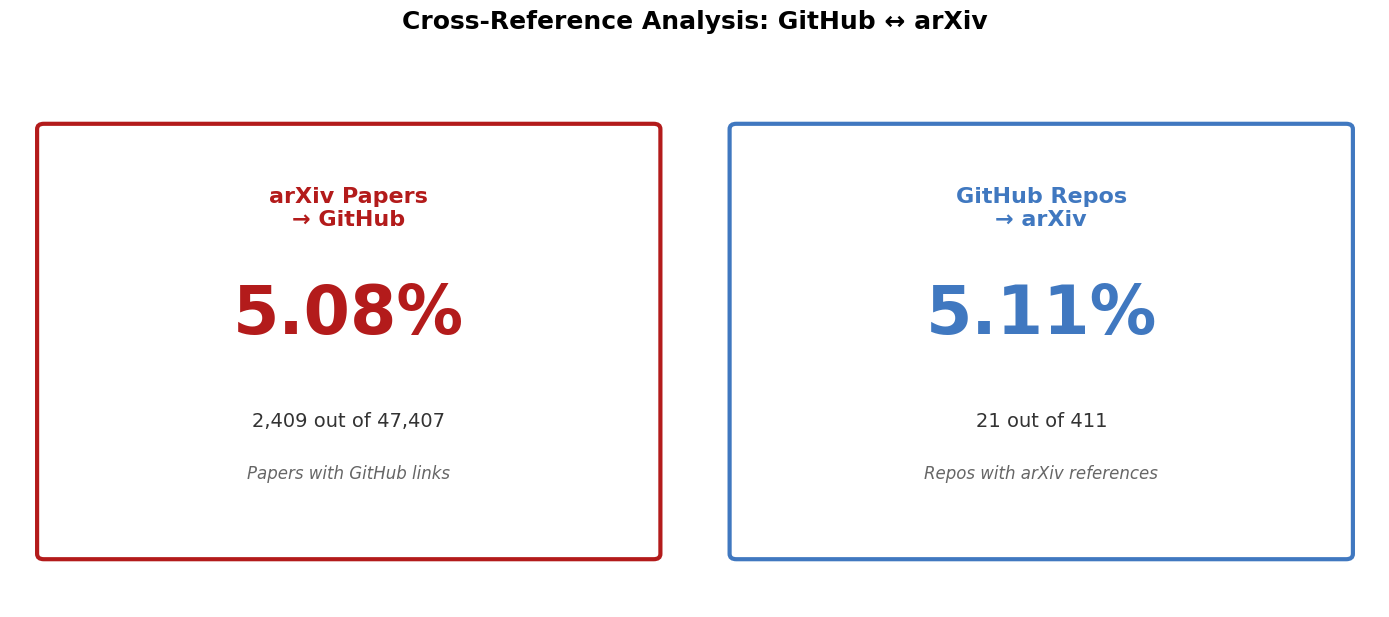

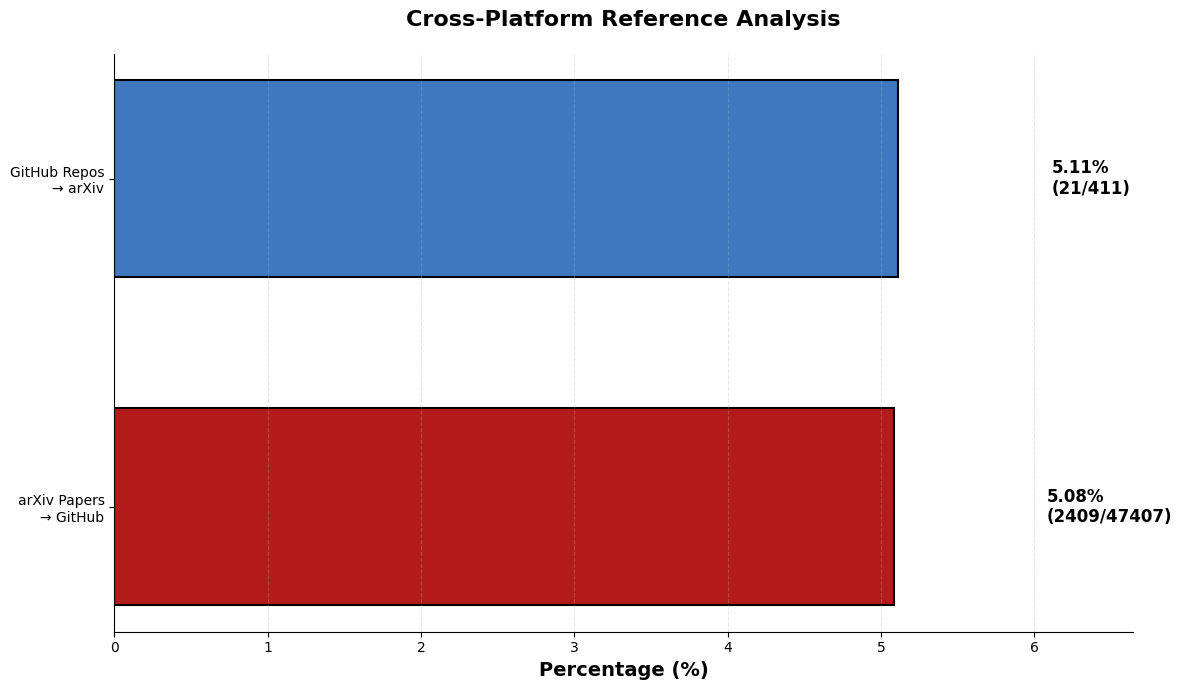

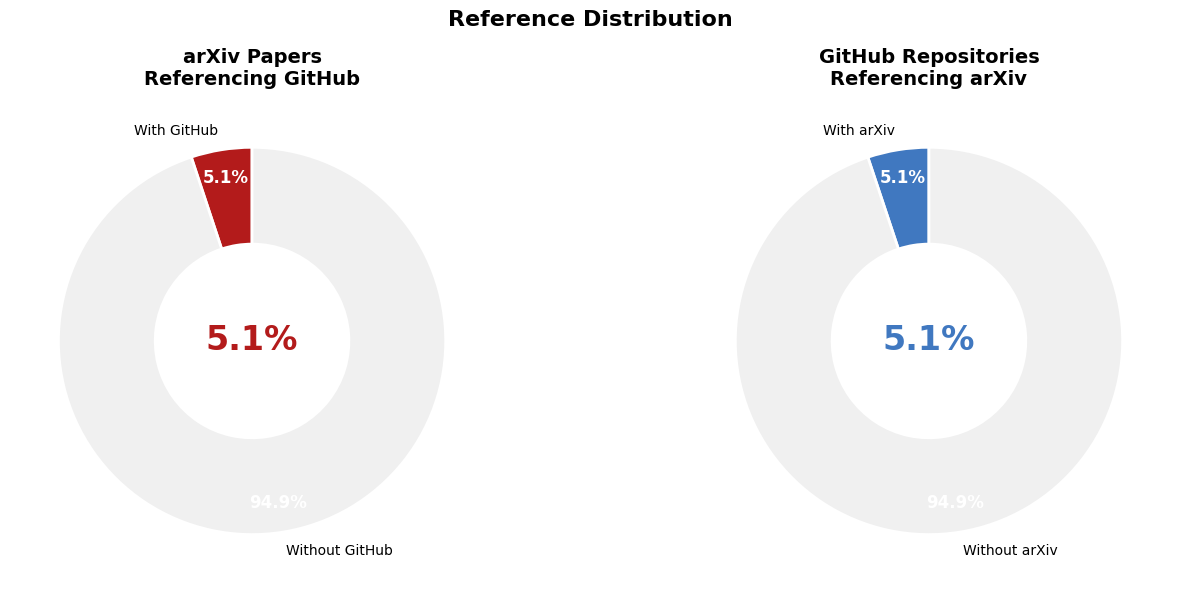

GitHub ↔ arXiv Cross-Reference Analysis

📊 arXiv Papers → GitHub
   Total Papers: 47,407
   Papers with GitHub links: 2,409
   Percentage: 5.08%

📊 GitHub Repositories → arXiv
   Total Repositories: 411
   Repos with arXiv references: 21
   Percentage: 5.11%

🔍 Key Insights:
   • GitHub repos are 0.03% more likely to reference arXiv
     compared to arXiv papers referencing GitHub.
   • Limited code-sharing: Only 5.1% of papers link to GitHub
   • Moderate academic engagement in GitHub projects

💡 Interpretation:
   These metrics show the bidirectional relationship between academic
   research and open-source implementation. Higher percentages indicate
   stronger integration between theory and practice.

✅ 3 visualization files created:
   1. kpi_cards.png - KPI card style
   2. comparison_bar_chart.png - Horizontal bar comparison
   3. donut_charts.png - Distribution donuts


In [ ]:
# 논문과 오픈소스가 각각 서로의 링크를 참조하고 있는 비율 (github_readme, arxiv_abastract 분석)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import re

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 결측값 처리
df_github_readmes['readme'] = df_github_readmes['readme'].fillna('')
df_arxiv['abstract'] = df_arxiv['abstract'].fillna('')

# URL 패턴 정의
github_pattern = r'github\.com'
arxiv_pattern = r'arxiv\.org'

# 1. arXiv 논문에서 GitHub URL 포함 비율
arxiv_with_github = df_arxiv['abstract'].str.contains(github_pattern, case=False, regex=True)
arxiv_github_count = arxiv_with_github.sum()
arxiv_total = len(df_arxiv)
arxiv_github_ratio = (arxiv_github_count / arxiv_total * 100) if arxiv_total > 0 else 0

# 2. GitHub README에서 arXiv URL 포함 비율
github_with_arxiv = df_github_readmes['readme'].str.contains(arxiv_pattern, case=False, regex=True)
github_arxiv_count = github_with_arxiv.sum()
github_total = len(df_github_readmes)
github_arxiv_ratio = (github_arxiv_count / github_total * 100) if github_total > 0 else 0

# 데이터 준비
data = {
    'category': ['arXiv Papers\n→ GitHub', 'GitHub Repos\n→ arXiv'],
    'ratio': [arxiv_github_ratio, github_arxiv_ratio],
    'count': [arxiv_github_count, github_arxiv_count],
    'total': [arxiv_total, github_total],
    'colors': ['#b31b1b', '#4078c0']
}

# ========================================
# 시각화 1: KPI 카드 스타일
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Cross-Reference Analysis: GitHub ↔ arXiv', 
             fontsize=18, fontweight='bold', y=1.02)

for idx, ax in enumerate(axes):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # 배경 카드
    card = FancyBboxPatch((0.5, 1), 9, 8, 
                          boxstyle="round,pad=0.1", 
                          edgecolor=data['colors'][idx], 
                          facecolor='white',
                          linewidth=3)
    ax.add_patch(card)
    
    # 제목
    ax.text(5, 7.5, data['category'][idx], 
            ha='center', va='center', 
            fontsize=16, fontweight='bold',
            color=data['colors'][idx])
    
    # 메인 비율 (큰 숫자)
    ax.text(5, 5.5, f"{data['ratio'][idx]:.2f}%", 
            ha='center', va='center', 
            fontsize=48, fontweight='bold',
            color=data['colors'][idx])
    
    # 상세 정보
    detail_text = f"{data['count'][idx]:,} out of {data['total'][idx]:,}"
    ax.text(5, 3.5, detail_text, 
            ha='center', va='center', 
            fontsize=14, color='#333333')
    
    # 라벨
    if idx == 0:
        label = "Papers with GitHub links"
    else:
        label = "Repos with arXiv references"
    
    ax.text(5, 2.5, label, 
            ha='center', va='center', 
            fontsize=12, style='italic', color='#666666')

plt.tight_layout()
plt.savefig('kpi_cards.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ========================================
# 시각화 2: 비교 막대 차트
# ========================================
fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.barh(data['category'], data['ratio'], 
               color=data['colors'], 
               edgecolor='black', 
               linewidth=1.5,
               height=0.6)

# 막대 위에 퍼센트 표시
for i, (bar, ratio, count, total) in enumerate(zip(bars, data['ratio'], data['count'], data['total'])):
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
            f'{ratio:.2f}%\n({count}/{total})',
            ha='left', va='center', 
            fontsize=12, fontweight='bold')

# 스타일링
ax.set_xlabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_title('Cross-Platform Reference Analysis', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlim(0, max(data['ratio']) * 1.3)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('comparison_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 시각화 3: 도넛 차트 with 상세 정보
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Reference Distribution', fontsize=16, fontweight='bold', y=0.98)

# arXiv → GitHub
arxiv_data = [arxiv_github_count, arxiv_total - arxiv_github_count]
arxiv_labels = ['With GitHub', 'Without GitHub']
arxiv_colors = ['#b31b1b', '#f0f0f0']

wedges1, texts1, autotexts1 = axes[0].pie(arxiv_data, 
                                            labels=arxiv_labels,
                                            colors=arxiv_colors,
                                            autopct='%1.1f%%',
                                            startangle=90,
                                            pctdistance=0.85,
                                            wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2))

for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

axes[0].set_title('arXiv Papers\nReferencing GitHub', 
                  fontsize=14, fontweight='bold', pad=10)
axes[0].text(0, 0, f'{arxiv_github_ratio:.1f}%', 
             ha='center', va='center', 
             fontsize=24, fontweight='bold', color='#b31b1b')

# GitHub → arXiv
github_data = [github_arxiv_count, github_total - github_arxiv_count]
github_labels = ['With arXiv', 'Without arXiv']
github_colors = ['#4078c0', '#f0f0f0']

wedges2, texts2, autotexts2 = axes[1].pie(github_data, 
                                            labels=github_labels,
                                            colors=github_colors,
                                            autopct='%1.1f%%',
                                            startangle=90,
                                            pctdistance=0.85,
                                            wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2))

for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

axes[1].set_title('GitHub Repositories\nReferencing arXiv', 
                  fontsize=14, fontweight='bold', pad=10)
axes[1].text(0, 0, f'{github_arxiv_ratio:.1f}%', 
             ha='center', va='center', 
             fontsize=24, fontweight='bold', color='#4078c0')

plt.tight_layout()
plt.savefig('donut_charts.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 통계 정보 출력
# ========================================
print("=" * 70)
print("GitHub ↔ arXiv Cross-Reference Analysis")
print("=" * 70)

print(f"\n📊 arXiv Papers → GitHub")
print(f"   Total Papers: {arxiv_total:,}")
print(f"   Papers with GitHub links: {arxiv_github_count:,}")
print(f"   Percentage: {arxiv_github_ratio:.2f}%")

print(f"\n📊 GitHub Repositories → arXiv")
print(f"   Total Repositories: {github_total:,}")
print(f"   Repos with arXiv references: {github_arxiv_count:,}")
print(f"   Percentage: {github_arxiv_ratio:.2f}%")

print(f"\n🔍 Key Insights:")

if arxiv_github_ratio > github_arxiv_ratio:
    ratio_diff = arxiv_github_ratio - github_arxiv_ratio
    print(f"   • arXiv papers are {ratio_diff:.2f}% more likely to reference GitHub")
    print(f"     compared to GitHub repos referencing arXiv papers.")
else:
    ratio_diff = github_arxiv_ratio - arxiv_github_ratio
    print(f"   • GitHub repos are {ratio_diff:.2f}% more likely to reference arXiv")
    print(f"     compared to arXiv papers referencing GitHub.")

if arxiv_github_ratio > 50:
    print(f"   • Strong code-sharing culture: Over half of papers provide GitHub links!")
elif arxiv_github_ratio > 20:
    print(f"   • Moderate code-sharing: {arxiv_github_ratio:.1f}% of papers link to GitHub")
else:
    print(f"   • Limited code-sharing: Only {arxiv_github_ratio:.1f}% of papers link to GitHub")

if github_arxiv_ratio > 10:
    print(f"   • Strong theoretical foundation: {github_arxiv_ratio:.1f}% of repos cite arXiv papers")
elif github_arxiv_ratio > 5:
    print(f"   • Moderate academic engagement in GitHub projects")
else:
    print(f"   • Limited academic references in repository descriptions")

print(f"\n💡 Interpretation:")
print(f"   These metrics show the bidirectional relationship between academic")
print(f"   research and open-source implementation. Higher percentages indicate")
print(f"   stronger integration between theory and practice.")

print("\n✅ 3 visualization files created:")
print("   1. kpi_cards.png - KPI card style")
print("   2. comparison_bar_chart.png - Horizontal bar comparison")
print("   3. donut_charts.png - Distribution donuts")
print("=" * 70)

GitHub–arXiv 상호참조 비율 분석
“연구와 오픈소스는 실제로 서로를 얼마나 직접적으로 연결하고 있을까?”

🔹 핵심 아이디어
arXiv 논문 중 GitHub 링크를 포함한 논문 비율,
GitHub 저장소 중 arXiv 논문을 언급한 비율을 각각 계산
논문과 오픈소스가 서로를 직접 참조하는 실질적 연결성 측정

🔹 시각화
1️⃣ Cross-Reference Summary (상단 그래프)
arXiv → GitHub: 5.08% (2,409/47,407)
GitHub → arXiv: 5.11% (21/411)
두 방향 모두 약 5% 수준의 상호참조가 존재

2️⃣ Reference Distribution (하단 그래프)
도넛 차트 형태로 ‘참조 있음’(약 5%) vs ‘참조 없음’(약 95%) 분포 표현
시각적으로 “연결은 존재하지만 여전히 드묾”을 강조

🔹 판별 포인트
논문이 GitHub 링크를 포함하는 비율과 레포지토리가 논문을 인용하는 비율이 거의 동일
비율은 낮지만 대칭적 구조 → “연구와 개발 간 직접 연결은 아직 제한적”
연구자와 개발자 커뮤니티 간 상호참조 생태계의 초기 단계를 시사

🔹 결론
arXiv 논문과 GitHub 저장소는 약 5%만이 서로를 직접 연결하고 있음.
이는 연구 결과가 오픈소스로, 또는 오픈소스가 연구로 이어지는 직접적 연결은 아직 드물지만 존재함을 의미.
즉, “연구와 실무가 연결되기 시작했지만, 여전히 초기 단계에 머물러 있다”고 해석할 수 있다.

Loading data...
Data preprocessing...
Papers: 100, GitHub repos: 100
Loading Sentence-BERT model...
Encoding paper abstracts...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Encoding GitHub READMEs...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating cosine similarity...
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Similarity calculation complete! Total 100 matches

Statistical Analysis:
  Pearson correlation: 0.0537 (p-value: 5.9571e-01)
  Spearman correlation: 0.0375 (p-value: 7.1117e-01)
  Mean similarity: 0.6208
  Mean stars: 4483.6

Creating visualization...
Graph saved: paper_readme_similarity_analysis.png


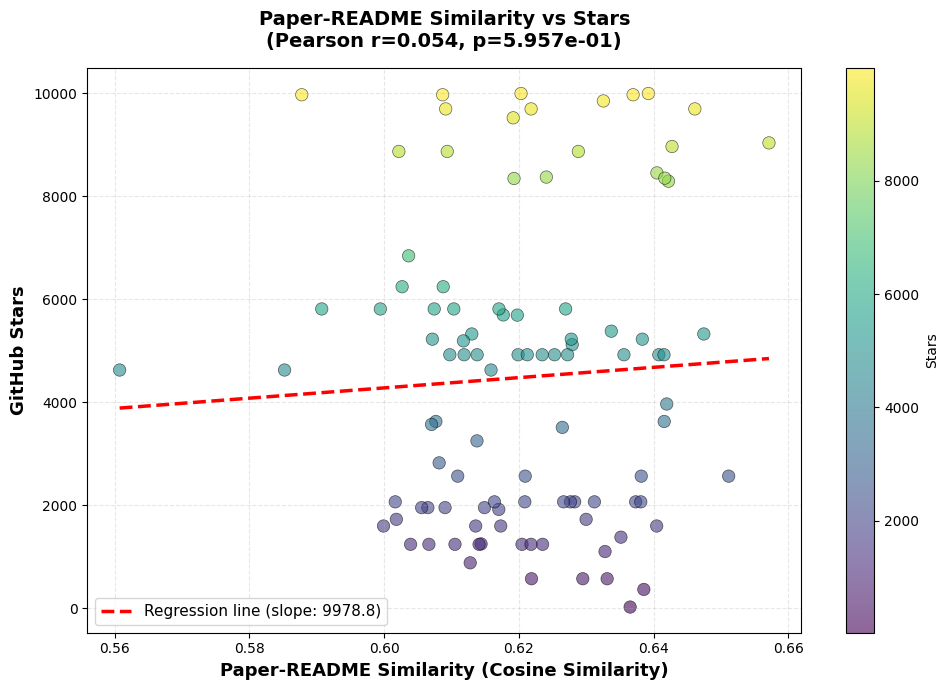

Results saved: similarity_star_results.csv

Top 5 highest similarity matches:
  Similarity: 0.6571 | Stars: 9,034.0
  Similarity: 0.6511 | Stars: 2,562.0
  Similarity: 0.6474 | Stars: 5,323.0
  Similarity: 0.6461 | Stars: 9,694.0
  Similarity: 0.6427 | Stars: 8,964.0

Bottom 5 lowest similarity matches:
  Similarity: 0.5607 | Stars: 4,623.0
  Similarity: 0.5852 | Stars: 4,623.0
  Similarity: 0.5878 | Stars: 9,969.0
  Similarity: 0.5907 | Stars: 5,809.0
  Similarity: 0.5994 | Stars: 5,809.0


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Font settings for matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ========================================
# 1. 데이터 로드
# ========================================
print("Loading data...")
# df_arxiv = pd.read_csv('arxiv_papers.csv')  # needs 'abstract' column
# df_merged_github = pd.read_csv('github_repos.csv')  # needs 'readme', 'stargazers_count' columns

# Sample data (replace with your actual data)
df_arxiv = pd.DataFrame({
    'paper_id': range(1, 101),
    'abstract': [f"This paper studies deep learning methods for computer vision and image recognition task {i}" for i in range(100)]
})

df_merged_github = pd.DataFrame({
    'repo_id': range(1, 201),
    'readme': [f"This repository implements neural networks for vision applications number {i}" if i % 2 == 0 
               else f"A simple web framework for building REST APIs {i}" for i in range(200)],
    'stargazers_count': np.random.randint(10, 10000, 200)
})

# ========================================
# 2. 데이터 전처리
# ========================================
print("Data preprocessing...")

# Remove missing values
df_arxiv = df_arxiv.dropna(subset=['abstract'])
df_merged_github = df_merged_github.dropna(subset=['readme', 'stargazers_count'])

# Clean text (remove empty strings)
df_arxiv = df_arxiv[df_arxiv['abstract'].str.strip() != '']
df_merged_github = df_merged_github[df_merged_github['readme'].str.strip() != '']

# Remove too-short READMEs (optional)
df_merged_github = df_merged_github[df_merged_github['readme'].str.len() > 50]

print(f"Papers: {len(df_arxiv)}, GitHub repos: {len(df_merged_github)}")

# ========================================
# 3. Sentence-BERT 모델 로드 및 임베딩
# ========================================
print("Loading Sentence-BERT model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and efficient
# For better accuracy: 'all-mpnet-base-v2'

print("Encoding paper abstracts...")
arxiv_embeddings = model.encode(df_arxiv['abstract'].tolist(), 
                                show_progress_bar=True,
                                batch_size=32)

print("Encoding GitHub READMEs...")
github_embeddings = model.encode(df_merged_github['readme'].tolist(), 
                                 show_progress_bar=True,
                                 batch_size=32)

# ========================================
# 4. 유사도 계산
# ========================================
print("Calculating cosine similarity...")

# Find most similar GitHub repo for each paper
max_similarities = []
matched_stars = []

for i, paper_emb in enumerate(arxiv_embeddings):
    # Calculate similarity between this paper and all GitHub READMEs
    similarities = cosine_similarity([paper_emb], github_embeddings)[0]
    
    # Get index of most similar repo
    max_idx = np.argmax(similarities)
    max_sim = similarities[max_idx]
    
    max_similarities.append(max_sim)
    matched_stars.append(df_merged_github.iloc[max_idx]['stargazers_count'])
    
    if (i + 1) % 10 == 0:
        print(f"  Progress: {i+1}/{len(arxiv_embeddings)}")

# Create results dataframe
results_df = pd.DataFrame({
    'similarity': max_similarities,
    'stars': matched_stars
})

print(f"\nSimilarity calculation complete! Total {len(results_df)} matches")

# ========================================
# 5. 통계 분석
# ========================================
print("\nStatistical Analysis:")
correlation, p_value = stats.pearsonr(results_df['similarity'], results_df['stars'])
spearman_corr, spearman_p = stats.spearmanr(results_df['similarity'], results_df['stars'])

print(f"  Pearson correlation: {correlation:.4f} (p-value: {p_value:.4e})")
print(f"  Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")
print(f"  Mean similarity: {results_df['similarity'].mean():.4f}")
print(f"  Mean stars: {results_df['stars'].mean():.1f}")

# ========================================
# 6. 시각화
# ========================================
print("\nCreating visualization...")

fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot
scatter = ax.scatter(results_df['similarity'], 
                     results_df['stars'],
                     alpha=0.6,
                     c=results_df['stars'],
                     cmap='viridis',
                     s=80,
                     edgecolors='black',
                     linewidth=0.5)

# Regression line
z = np.polyfit(results_df['similarity'], results_df['stars'], 1)
p = np.poly1d(z)
x_line = np.linspace(results_df['similarity'].min(), 
                     results_df['similarity'].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2.5, 
        label=f'Regression line (slope: {z[0]:.1f})')

# Styling
ax.set_xlabel('Paper-README Similarity (Cosine Similarity)', fontsize=13, fontweight='bold')
ax.set_ylabel('GitHub Stars', fontsize=13, fontweight='bold')
ax.set_title(f'Paper-README Similarity vs Stars\n(Pearson r={correlation:.3f}, p={p_value:.3e})', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.colorbar(scatter, ax=ax, label='Stars')

plt.tight_layout()
plt.savefig('paper_readme_similarity_analysis.png', dpi=300, bbox_inches='tight')
print("Graph saved: paper_readme_similarity_analysis.png")
plt.show()

# ========================================
# 7. Save results
# ========================================
results_df.to_csv('similarity_star_results.csv', index=False, encoding='utf-8-sig')
print("Results saved: similarity_star_results.csv")

# ========================================
# 8. Additional analysis: Top/Bottom similarity examples
# ========================================
print("\nTop 5 highest similarity matches:")
top_5 = results_df.nlargest(5, 'similarity')
for idx, row in top_5.iterrows():
    print(f"  Similarity: {row['similarity']:.4f} | Stars: {row['stars']:,}")

print("\nBottom 5 lowest similarity matches:")
bottom_5 = results_df.nsmallest(5, 'similarity')
for idx, row in bottom_5.iterrows():
    print(f"  Similarity: {row['similarity']:.4f} | Stars: {row['stars']:,}")

README–논문 유사도 vs Star/Fork 상관관계 그래프
“연구 내용과 유사한 오픈소스일수록 인기가 높은가?”

🔹 핵심 아이디어
논문 abstract와 README readme_content를 문장 임베딩(예: Sentence-BERT)으로 변환
cosine similarity로 “연구–레포 유사도” 계산
그 유사도 점수를 X축, GitHub 별(stargazers_count) 수를 Y축으로 그림

🔹 시각화
Scatter plot + 회귀선
X축: 논문–README 유사도
Y축: 별(star) 수
회귀선이 상승하면 → 연관성 있음
평평하면 → 연관성 없음

🔹 판별 포인트
회귀선 기울기(β) > 0 이고 상관계수 r > 0.3 → “연구와 구현 간 연관성 있음”
💡 “논문 내용과 유사한 오픈소스일수록 star 수가 높다” → 연구 내용이 실무에 영향을 준다는 증거.

🔹 결론
논문과 관계가 커질수록 repository의 인기가 많은 추세이긴하나 회귀선의 기울기가 완만하기 때문에 큰 영향은 받지 않는 걸로 보인다.